# Visualizing the Results

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_parquet("cache/all_df.parquet")

In [71]:
df.head()

Cap     Ded   LR     Pol_Lim  NOINS  growth_rate_mean  \
0  100000000  100000  0.6           0    NaN          0.013609   
1  100000000  100000  0.6  1000000000    NaN          0.013404   
2  100000000  100000  0.6   100000000    NaN          0.011205   
3  100000000  100000  0.6    10000000    NaN          0.008385   
4  100000000  100000  0.6   110000000    NaN          0.011457   

   growth_rate_std  growth_rate_cv  growth_rate_skewness  \
0         0.039920        2.933261             -5.354307   
1         0.010741        0.801346            -19.588397   
2         0.028496        2.543190             -6.844083   
3         0.037413        4.461780             -5.278833   
4         0.027830        2.429185             -7.000897   

   growth_rate_kurtosis  ...  growth_rate_q95  growth_rate_q99  \
0             35.655400  ...         0.029548         0.030668   
1            424.167486  ...         0.014328         0.014462   
2             52.624839  ...         0.016537         0.016669   
3             33.571227  ...         0.020400         0.020570   
4             54.912309  ...         0.016510         0.016645   

   growth_rate_cte_q0.5  growth_rate_cte_q1.0  growth_rate_cte_q5.0  \
0             -0.188884             -0.154951             -0.034219   
1              0.013375              0.013484              0.013656   
2             -0.168862             -0.164937              0.007606   
3             -0.165719             -0.160514             -0.030976   
4             -0.168427             -0.164455              0.010289   

   risk_of_ruin_5  risk_of_ruin_10  risk_of_ruin_15  risk_of_ruin_20  \
0         0.00738          0.01485          0.02192          0.02935   
1         0.00062          0.00122          0.00180          0.00234   
2         0.00409          0.00806          0.01229          0.01641   
3         0.00714          0.01404          0.02106          0.02748   
4         0.00370          0.00776          0.01186          0.01575   

   risk_of_ruin_25  
0          0.03599  
1          0.00298  
2          0.02073  
3          0.03345  
4          0.01999  

[5 rows x 35 columns]

In [138]:
df.columns

Index(['Cap', 'Ded', 'LR', 'Pol_Lim', 'NOINS', 'growth_rate_mean',
       'growth_rate_std', 'growth_rate_cv', 'growth_rate_skewness',
       'growth_rate_kurtosis', 'growth_rate_hyperskewness',
       'growth_rate_hyperkurtosis', 'growth_rate_q1', 'growth_rate_q5',
       'growth_rate_q10', 'growth_rate_q20', 'growth_rate_q30',
       'growth_rate_q40', 'growth_rate_q50', 'growth_rate_q60',
       'growth_rate_q70', 'growth_rate_q75', 'growth_rate_q80',
       'growth_rate_q85', 'growth_rate_q90', 'growth_rate_q95',
       'growth_rate_q99', 'growth_rate_cte_q0.5', 'growth_rate_cte_q1.0',
       'growth_rate_cte_q5.0', 'risk_of_ruin_5', 'risk_of_ruin_10',
       'risk_of_ruin_15', 'risk_of_ruin_20', 'risk_of_ruin_25'],
      dtype='object')

In [143]:
def find_ror_boundaries(group):
    """
    For a given Cap level, find the policy limit where RoR crosses 1%
    and interpolate to get the exact policy limit at 1% RoR.
    """
    # Sort by policy limit to ensure proper ordering
    group = group.sort_values('Pol_Lim')
    
    # Find where RoR transitions from above 1% to below 1%
    above_1pct = group[group['risk_of_ruin_25'] > 0.01]
    below_1pct = group[group['risk_of_ruin_25'] <= 0.01]

    # Find where RoR transitions from above 1% to below 1%
    above_0p5pct = group[group['risk_of_ruin_25'] > 0.005]
    below_0p5pct = group[group['risk_of_ruin_25'] <= 0.005]

    # Find where RoR transitions from above 1% to below 1%
    above_2p5pct = group[group['risk_of_ruin_25'] > 0.025]
    below_2p5pct = group[group['risk_of_ruin_25'] <= 0.025]
    
    # Check if we have both bounds
    if len(above_1pct) == 0 or len(below_1pct) == 0:
        return pd.Series({
            'Cap': group['Cap'].iloc[0],
            # 1% RoR
            'Pol_Lim_at_1pct_RoR': np.nan,
            'Pol_Lim_above_1pct_RoR': np.nan,
            'Pol_Lim_below_1pct_RoR': np.nan,
            'Lower_1pct_RoR': np.nan,
            'Upper_1pct_RoR': np.nan,
            # 0.5% RoR
            'Pol_Lim_at_0p5pct_RoR': np.nan,
            'Pol_Lim_above_0p5pct_RoR': np.nan,
            'Pol_Lim_below_0p5pct_RoR': np.nan,
            'Lower_0p5pct_RoR': np.nan,
            'Upper_0p5pct_RoR': np.nan,
            # 2.5% RoR
            'Pol_Lim_at_2p5pct_RoR': np.nan,
            'Pol_Lim_above_2p5pct_RoR': np.nan,
            'Pol_Lim_below_2p5pct_RoR': np.nan,
            'Lower_2p5pct_RoR': np.nan,
            'Upper_2p5pct_RoR': np.nan
        })
    
    # Get the boundary points (highest Pol_Lim with RoR > 1% and lowest with RoR <= 1%)
    lower_bound_1pct = above_1pct.iloc[-1]  # Highest Pol_Lim still above 1%
    upper_bound_1pct = below_1pct.iloc[0]   # Lowest Pol_Lim at or below 1%
    
    # Get the boundary points (highest Pol_Lim with RoR > 0.5% and lowest with RoR <= 0.5%)
    lower_bound_0p5pct = above_0p5pct.iloc[-1]  # Highest Pol_Lim still above 0.5%
    upper_bound_0p5pct = below_0p5pct.iloc[0]   # Lowest Pol_Lim at or below 0.5%
    
    # Get the boundary points (highest Pol_Lim with RoR > 2.5% and lowest with RoR <= 2.5%)
    lower_bound_2p5pct = above_2p5pct.iloc[-1]  # Highest Pol_Lim still above 2.5%
    upper_bound_2p5pct = below_2p5pct.iloc[0]   # Lowest Pol_Lim at or below 2.5%
    
    # Interpolation Formula: x = x1 + (y - y1) * (x2 - x1) / (y2 - y1)
    # Linear interpolation to find exact Pol_Lim at 1% RoR
    pol_lim_lower_1pct = lower_bound_1pct['Pol_Lim']
    pol_lim_upper_1pct = upper_bound_1pct['Pol_Lim']
    ror_lower_1pct = lower_bound_1pct['risk_of_ruin_25']
    ror_upper_1pct = upper_bound_1pct['risk_of_ruin_25']
    interpolated_pol_lim_1pct = pol_lim_lower_1pct + (0.01 - ror_lower_1pct) * (pol_lim_upper_1pct - pol_lim_lower_1pct) / (ror_upper_1pct - ror_lower_1pct)
    # Linear interpolation to find exact Pol_Lim at 0.5% RoR
    pol_lim_lower_0p5pct = lower_bound_0p5pct['Pol_Lim']
    pol_lim_upper_0p5pct = upper_bound_0p5pct['Pol_Lim']
    ror_lower_0p5pct = lower_bound_0p5pct['risk_of_ruin_25']
    ror_upper_0p5pct = upper_bound_0p5pct['risk_of_ruin_25']
    interpolated_pol_lim_0p5pct = pol_lim_lower_0p5pct + (0.005 - ror_lower_0p5pct) * (pol_lim_upper_0p5pct - pol_lim_lower_0p5pct) / (ror_upper_0p5pct - ror_lower_0p5pct)
    # Linear interpolation to find exact Pol_Lim at 2.5% RoR
    pol_lim_lower_2p5pct = lower_bound_2p5pct['Pol_Lim']
    pol_lim_upper_2p5pct = upper_bound_2p5pct['Pol_Lim']
    ror_lower_2p5pct = lower_bound_2p5pct['risk_of_ruin_25']
    ror_upper_2p5pct = upper_bound_2p5pct['risk_of_ruin_25']
    interpolated_pol_lim_2p5pct = pol_lim_lower_2p5pct + (0.025 - ror_lower_2p5pct) * (pol_lim_upper_2p5pct - pol_lim_lower_2p5pct) / (ror_upper_2p5pct - ror_lower_2p5pct)

    return pd.Series({
        'Cap': group['Cap'].iloc[0],
        # 1% RoR
        'Pol_Lim_at_1pct_RoR': interpolated_pol_lim_1pct,
        'Pol_Lim_above_1pct_RoR': pol_lim_lower_1pct,
        'Pol_Lim_below_1pct_RoR': pol_lim_upper_1pct,
        'Lower_1pct_RoR': ror_lower_1pct,
        'Upper_1pct_RoR': ror_upper_1pct,
        # 0.5% RoR
        'Pol_Lim_at_0p5pct_RoR': interpolated_pol_lim_0p5pct,
        'Pol_Lim_above_0p5pct_RoR': pol_lim_lower_0p5pct,
        'Pol_Lim_below_0p5pct_RoR': pol_lim_upper_0p5pct,
        'Lower_0p5pct_RoR': ror_lower_0p5pct,
        'Upper_0p5pct_RoR': ror_upper_0p5pct,
        # 2.5% RoR
        'Pol_Lim_at_2p5pct_RoR': interpolated_pol_lim_2p5pct,
        'Pol_Lim_above_2p5pct_RoR': pol_lim_lower_2p5pct,
        'Pol_Lim_below_2p5pct_RoR': pol_lim_upper_2p5pct,
        'Lower_2p5pct_RoR': ror_lower_2p5pct,
        'Upper_2p5pct_RoR': ror_upper_2p5pct
    })

# Apply the function to each Cap group
boundary_df = df.groupby('Cap').apply(find_ror_boundaries).reset_index(drop=True)

# Display results
print(boundary_df)
print(f"\n{len(boundary_df)} capital levels analyzed")
print(f"{boundary_df['Pol_Lim_at_1pct_RoR'].notna().sum()} have interpolated 1% RoR boundaries")
print(f"{boundary_df['Pol_Lim_at_1pct_RoR'].isna().sum()} are missing boundaries (edge cases)")

           Cap  Pol_Lim_at_1pct_RoR  Pol_Lim_above_1pct_RoR  \
0    5000000.0         3.771186e+07              35000000.0   
1   10000000.0         6.264706e+07              60000000.0   
2   25000000.0         1.233000e+08             120000000.0   
3   50000000.0         1.980952e+08             190000000.0   
4   75000000.0         2.497701e+08             240000000.0   
5  100000000.0         3.181818e+08             310000000.0   

   Pol_Lim_below_1pct_RoR  Lower_1pct_RoR  Upper_1pct_RoR  \
0              40000000.0         0.01096         0.00919   
1              65000000.0         0.01018         0.00984   
2             130000000.0         0.01033         0.00933   
3             200000000.0         0.01051         0.00988   
4             250000000.0         0.01085         0.00998   
5             320000000.0         0.01009         0.00998   

   Pol_Lim_at_0p5pct_RoR  Pol_Lim_above_0p5pct_RoR  Pol_Lim_below_0p5pct_RoR  \
0           7.312500e+07                70000000.0

C:\Users\alexf\AppData\Local\Temp\ipykernel_67744\93524520.py:100: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  boundary_df = df.groupby('Cap').apply(find_ror_boundaries).reset_index(drop=True)


In [165]:
boundary_df[boundary_df['Cap'] == 10000000]

Cap  Pol_Lim_at_1pct_RoR  Pol_Lim_above_1pct_RoR  \
1  10000000.0         6.264706e+07              60000000.0   

   Pol_Lim_below_1pct_RoR  Lower_1pct_RoR  Upper_1pct_RoR  \
1              65000000.0         0.01018         0.00984   

   Pol_Lim_at_0p5pct_RoR  Pol_Lim_above_0p5pct_RoR  Pol_Lim_below_0p5pct_RoR  \
1           1.191919e+08               110000000.0               120000000.0   

   Lower_0p5pct_RoR  Upper_0p5pct_RoR  Pol_Lim_at_2p5pct_RoR  \
1           0.00591           0.00492           2.160207e+07   

   Pol_Lim_above_2p5pct_RoR  Pol_Lim_below_2p5pct_RoR  Lower_2p5pct_RoR  \
1                20000000.0                25000000.0           0.02624   

   Upper_2p5pct_RoR  
1           0.02237

In [72]:
df = df[df['Pol_Lim'] > 0].copy()
df['Pol_Lim'].value_counts()

Pol_Lim
1000000000    6
100000000     6
10000000      6
110000000     6
120000000     6
             ..
75000000      6
80000000      6
85000000      6
90000000      6
95000000      6
Name: count, Length: 67, dtype: int64

In [73]:
df = df[df['Cap'] > 0].copy()
df['Cap'].value_counts()

Cap
100000000    67
10000000     67
25000000     67
50000000     67
5000000      67
75000000     67
Name: count, dtype: int64

In [74]:
np.mean(df['growth_rate_mean'])

np.float64(0.0132502600714309)

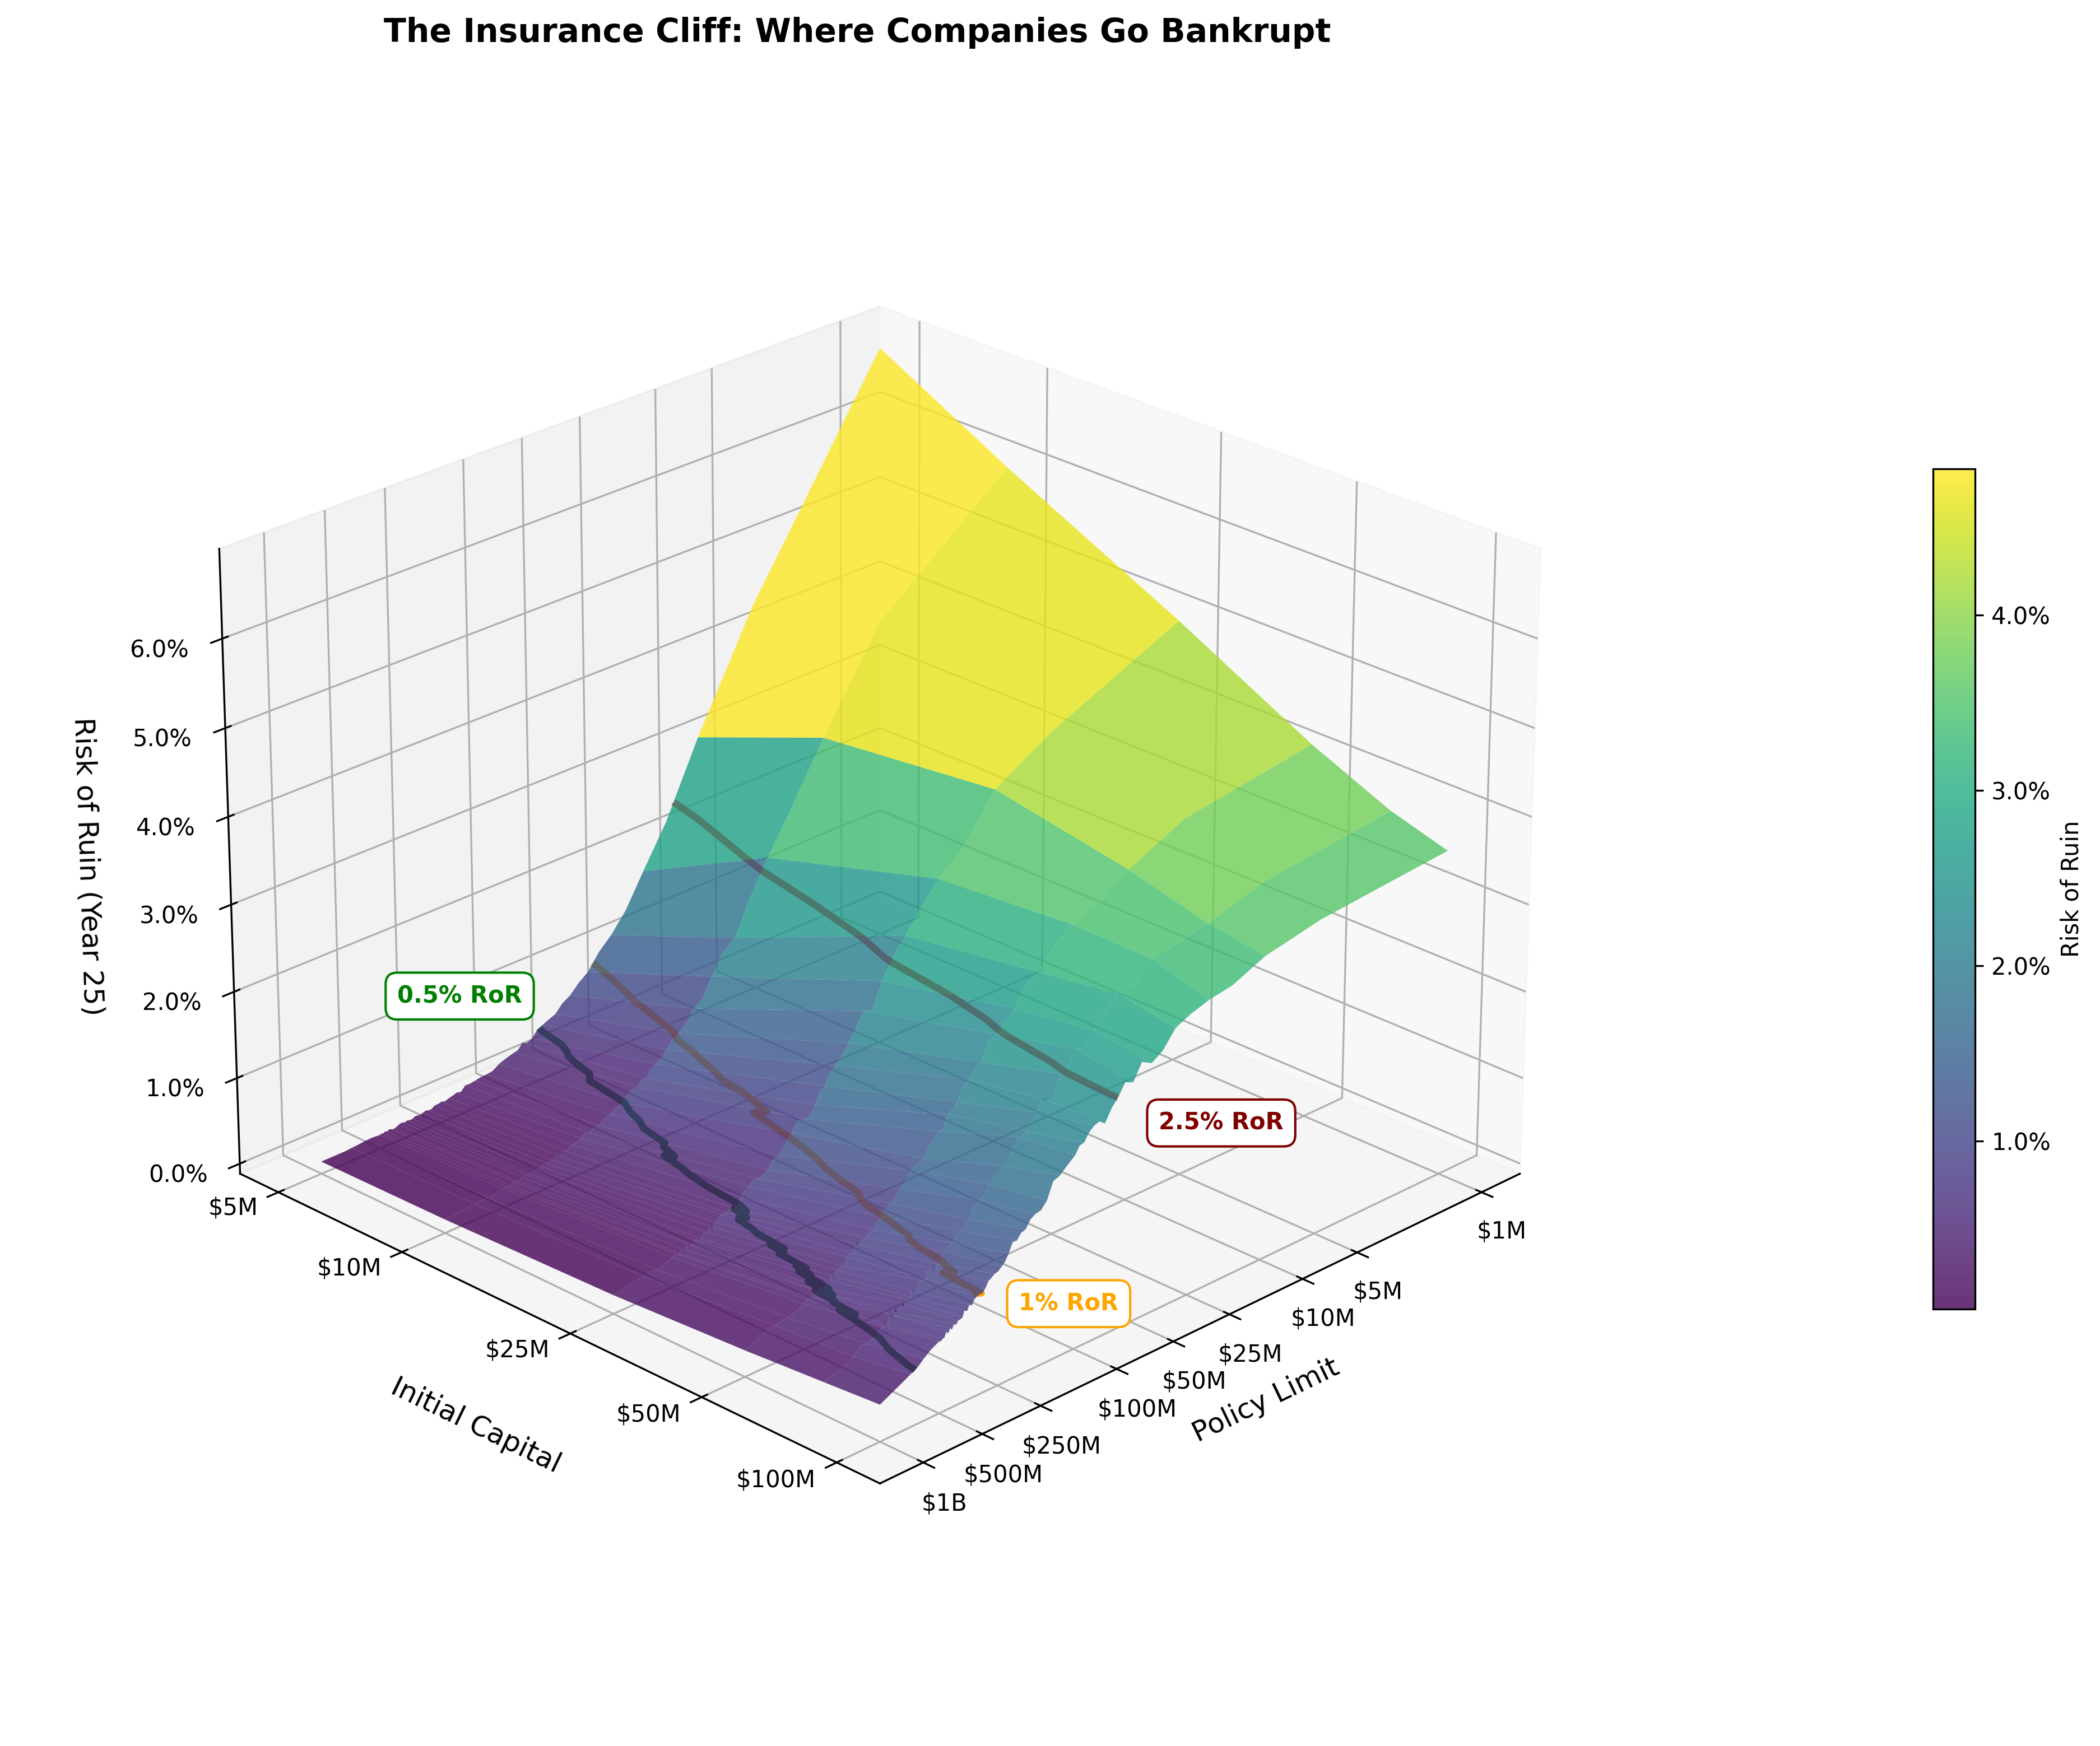

In [156]:
# Create surface plot of Risk of Ruin by Year 25
fig = plt.figure(figsize=(14, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Pivot the data to create a grid for the surface plot
pivot_data = df.pivot_table(
    values='risk_of_ruin_25',
    index='Cap',
    columns='Pol_Lim',
    aggfunc='mean'  # In case there are duplicates
)

# Create custom tick formatter for x-axis (Policy Limit in millions)
x_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
x_tick_positions = np.log10(x_ticks)
x_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in x_ticks]
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels, rotation=0, ha='center')

# Create custom tick formatter for y-axis (Initial Capital in millions)
y_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
y_tick_positions = np.log10(y_ticks)
y_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in y_ticks]
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels, rotation=0, ha='center')

# Create mesh grid
X, Y = np.meshgrid(pivot_data.columns, pivot_data.index)
Z = pivot_data.values

# Convert X and Y to log scale
X = np.log10(X)
Y = np.log10(Y)

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')

# Labels and title
ax.set_xlabel('Policy Limit', fontsize=12, labelpad=10)
ax.set_ylabel('Initial Capital', fontsize=12, labelpad=10)
ax.set_zlabel('Risk of Ruin (Year 25)', fontsize=12, labelpad=10)
ax.set_title('The Insurance Cliff: Where Companies Go Bankrupt', fontsize=14, pad=0, fontweight='bold')

# Add colorbar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='Risk of Ruin', pad=0.1, fraction=0.02, format=plt.FuncFormatter(lambda x, p: f'{x*100:.1f}%'))
# Adjust viewing angle for better visualization
ax.view_init(elev=25, azim=45)

# Center the y-axis tick labels
ax.yaxis.labelpad = 20
for t in ax.yaxis.get_major_ticks():
    t.label1.set_horizontalalignment('right')
    t.label1.set_verticalalignment('bottom')
# Add padding to z-axis tick labels
ax.zaxis.labelpad = 20
ax.tick_params(axis='z', pad=10)
ax.set_box_aspect(None, zoom=0.85)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig = plt.figure(constrained_layout=True)
# Format z-axis as percentages
ax.zaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*100:.1f}%'))

# Draw a prominent contour lines at 0.5%, 1%, and 2.5%
contour_risky = ax.contour(X, Y, Z, levels=[0.005], colors='green', linewidths=3, alpha=1)
contour_neutral = ax.contour(X, Y, Z, levels=[0.01], colors='orange', linewidths=3, alpha=1)
contour_averse = ax.contour(X, Y, Z, levels=[0.025], colors='red', linewidths=3, alpha=1)

# Add text annotation for the 0.5% contour line
ax.text(np.log10(80e6), np.log10(2.3e6), 0.001, '0.5% RoR', color='green', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='green', alpha=1))

# Add text annotation for the 1% contour line
ax.text(np.log10(300e6), np.log10(120e6), 0.01, '1% RoR', color='orange', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='orange', alpha=1))

# Add text annotation for the 2.5% contour line
ax.text(np.log10(15e6), np.log10(70e6), 0.012, '2.5% RoR', color='maroon', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='maroon', alpha=1))

if fig is not ax.figure:
    plt.close(fig)
plt.figure(ax.figure.number)
plt.savefig('cache/insurance_cliff_view_1.png', dpi=300, bbox_inches='tight')
plt.show()

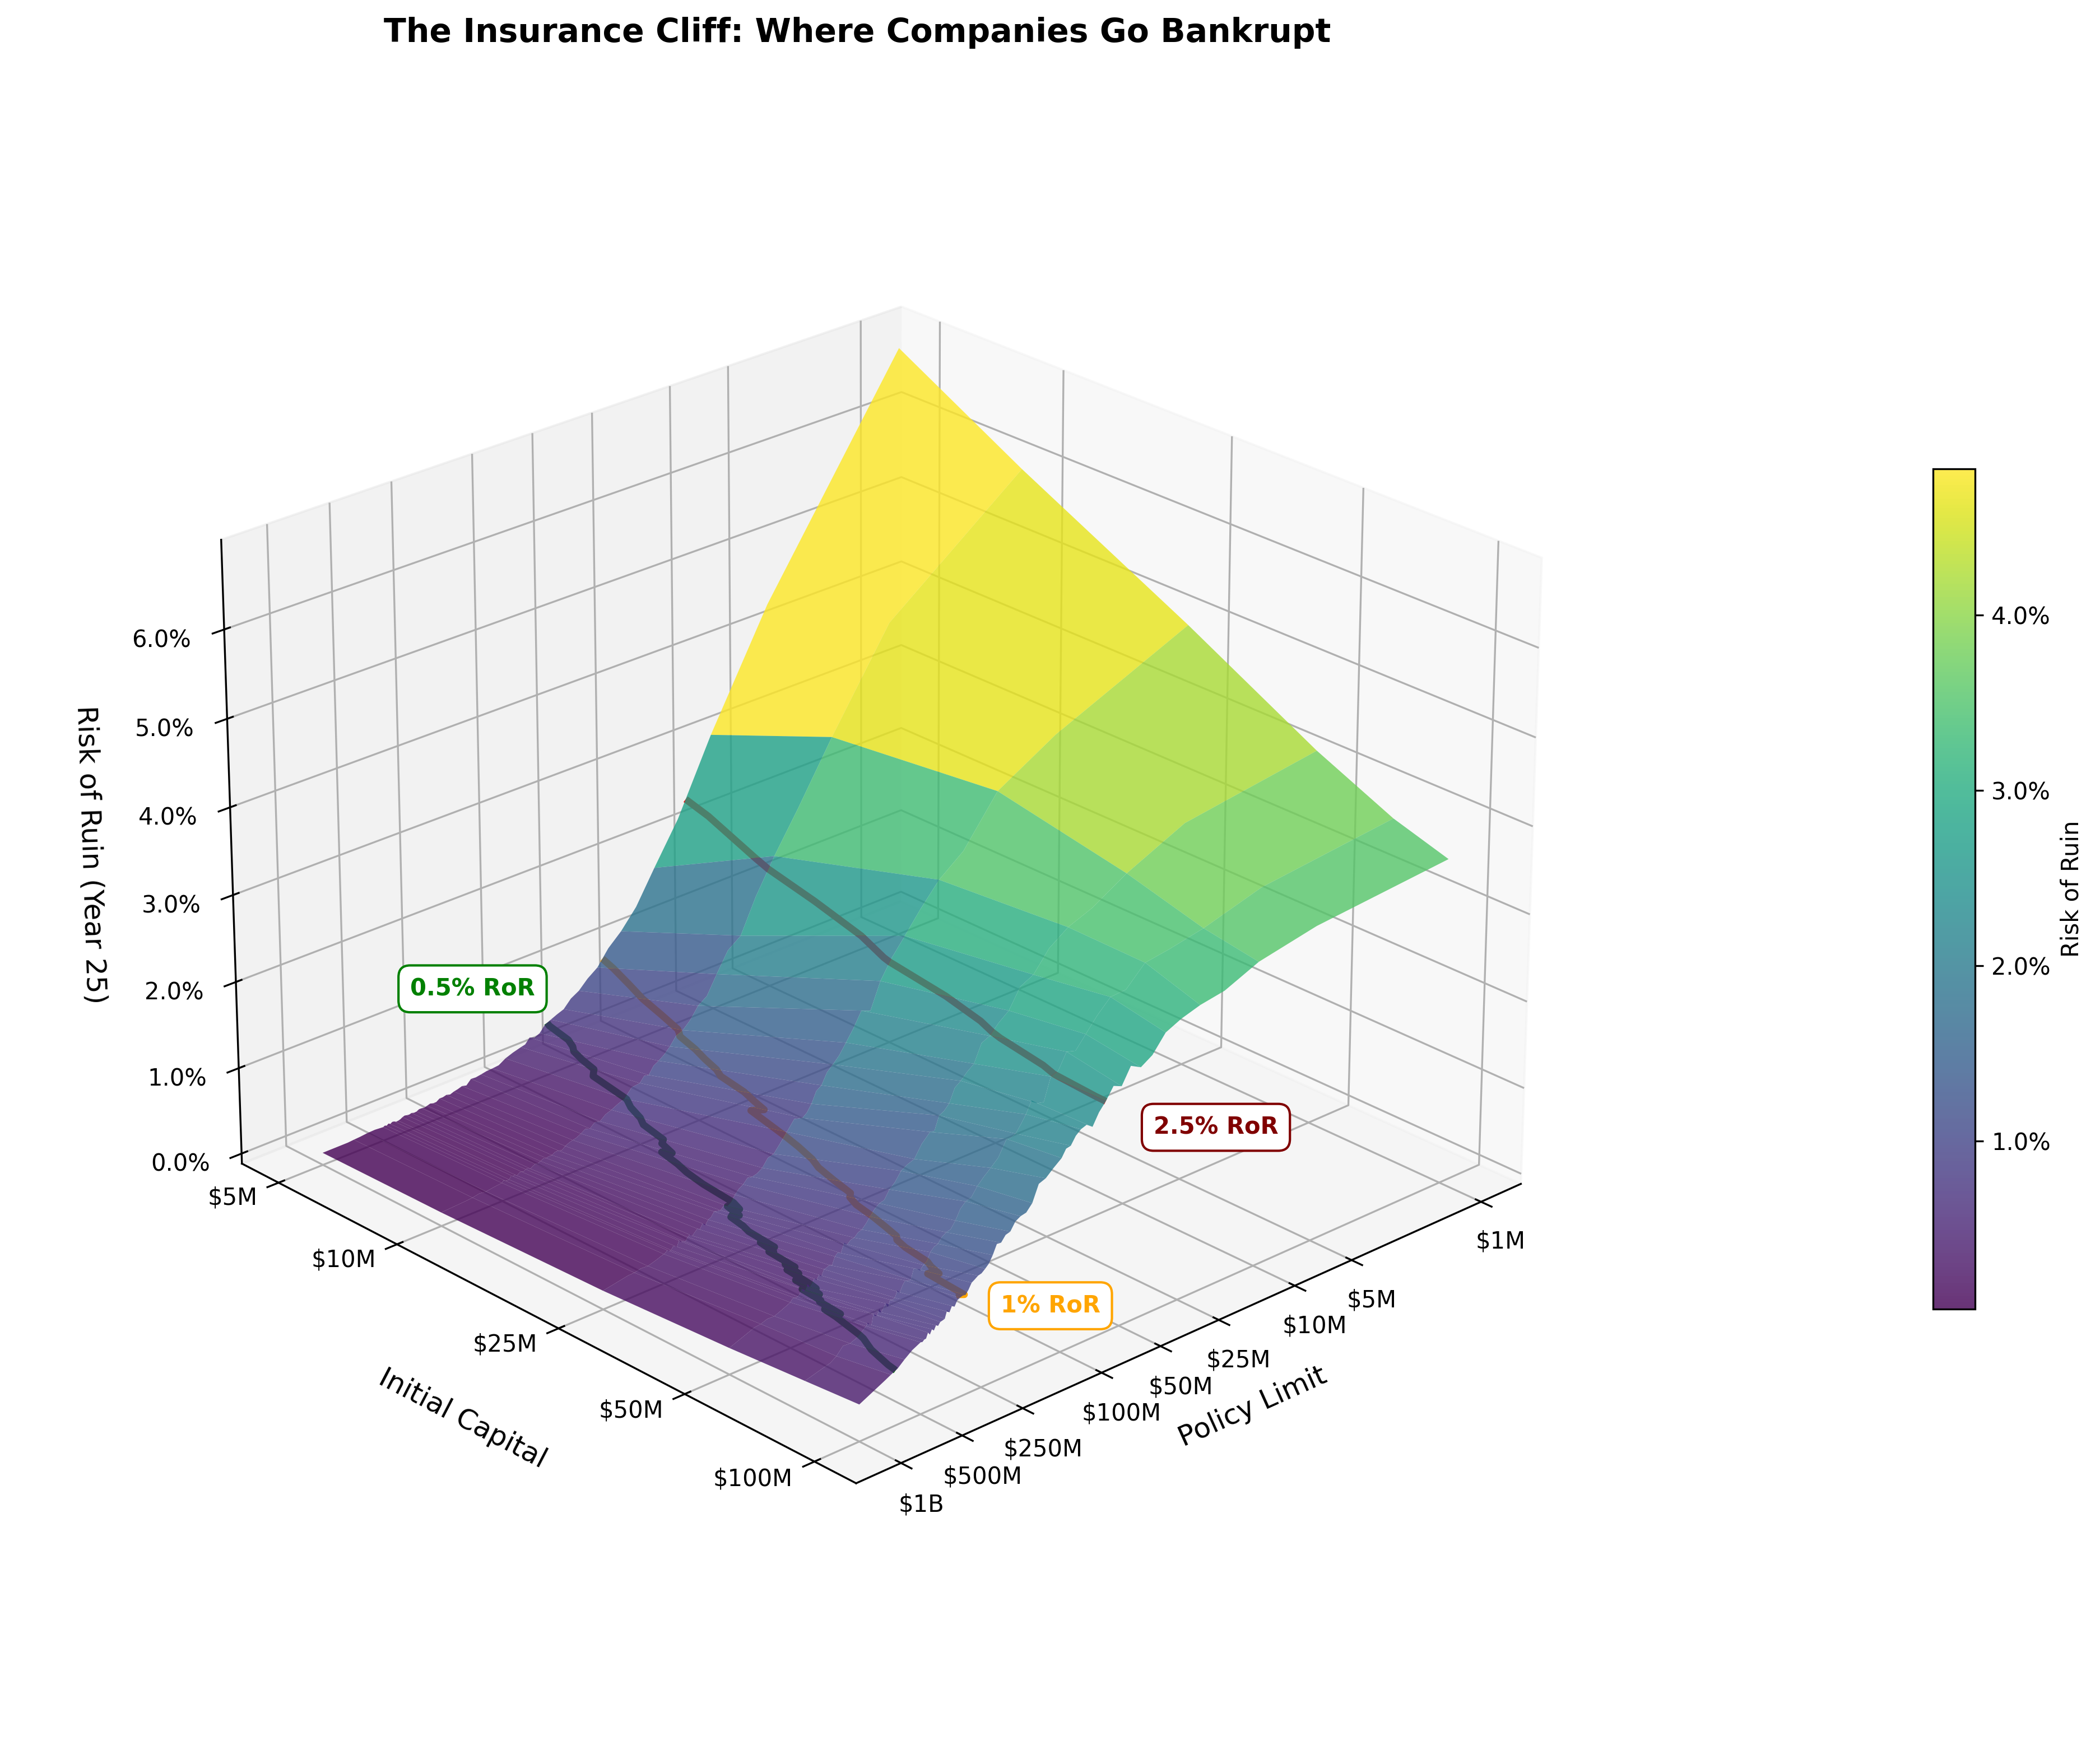

In [159]:
# Create surface plot of Risk of Ruin by Year 25
fig = plt.figure(figsize=(14, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Pivot the data to create a grid for the surface plot
pivot_data = df.pivot_table(
    values='risk_of_ruin_25',
    index='Cap',
    columns='Pol_Lim',
    aggfunc='mean'  # In case there are duplicates
)

# Create custom tick formatter for x-axis (Policy Limit in millions)
x_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
x_tick_positions = np.log10(x_ticks)
x_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in x_ticks]
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels, rotation=0, ha='center')

# Create custom tick formatter for y-axis (Initial Capital in millions)
y_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
y_tick_positions = np.log10(y_ticks)
y_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in y_ticks]
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels, rotation=0, ha='center')

# Create mesh grid
X, Y = np.meshgrid(pivot_data.columns, pivot_data.index)
Z = pivot_data.values

# Convert X and Y to log scale
X = np.log10(X)
Y = np.log10(Y)

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')

# Labels and title
ax.set_xlabel('Policy Limit', fontsize=12, labelpad=10)
ax.set_ylabel('Initial Capital', fontsize=12, labelpad=10)
ax.set_zlabel('Risk of Ruin (Year 25)', fontsize=12, labelpad=10)
ax.set_title('The Insurance Cliff: Where Companies Go Bankrupt', fontsize=14, pad=0, fontweight='bold')

# Add colorbar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='Risk of Ruin', pad=0.1, fraction=0.02, format=plt.FuncFormatter(lambda x, p: f'{x*100:.1f}%'))
# Adjust viewing angle for better visualization
ax.view_init(elev=25, azim=47)

# Center the y-axis tick labels
ax.yaxis.labelpad = 20
for t in ax.yaxis.get_major_ticks():
    t.label1.set_horizontalalignment('right')
    t.label1.set_verticalalignment('bottom')
# Add padding to z-axis tick labels
ax.zaxis.labelpad = 20
ax.tick_params(axis='z', pad=10)
ax.set_box_aspect(None, zoom=0.85)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig = plt.figure(constrained_layout=True)
# Format z-axis as percentages
ax.zaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*100:.1f}%'))

# Draw a prominent contour lines at 0.5%, 1%, and 2.5%
contour_risky = ax.contour(X, Y, Z, levels=[0.005], colors='green', linewidths=3, alpha=1)
contour_neutral = ax.contour(X, Y, Z, levels=[0.01], colors='orange', linewidths=3, alpha=1)
contour_averse = ax.contour(X, Y, Z, levels=[0.025], colors='red', linewidths=3, alpha=1)

# Add text annotation for the 0.5% contour line
ax.text(np.log10(80e6), np.log10(2.3e6), 0.001, '0.5% RoR', color='green', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='green', alpha=1))

# Add text annotation for the 1% contour line
ax.text(np.log10(300e6), np.log10(120e6), 0.01, '1% RoR', color='orange', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='orange', alpha=1))

# Add text annotation for the 2.5% contour line
ax.text(np.log10(15e6), np.log10(70e6), 0.012, '2.5% RoR', color='maroon', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='maroon', alpha=1))

if fig is not ax.figure:
    plt.close(fig)
plt.figure(ax.figure.number)
plt.savefig('cache/insurance_cliff_view_2.png', dpi=300, bbox_inches='tight')
plt.show()

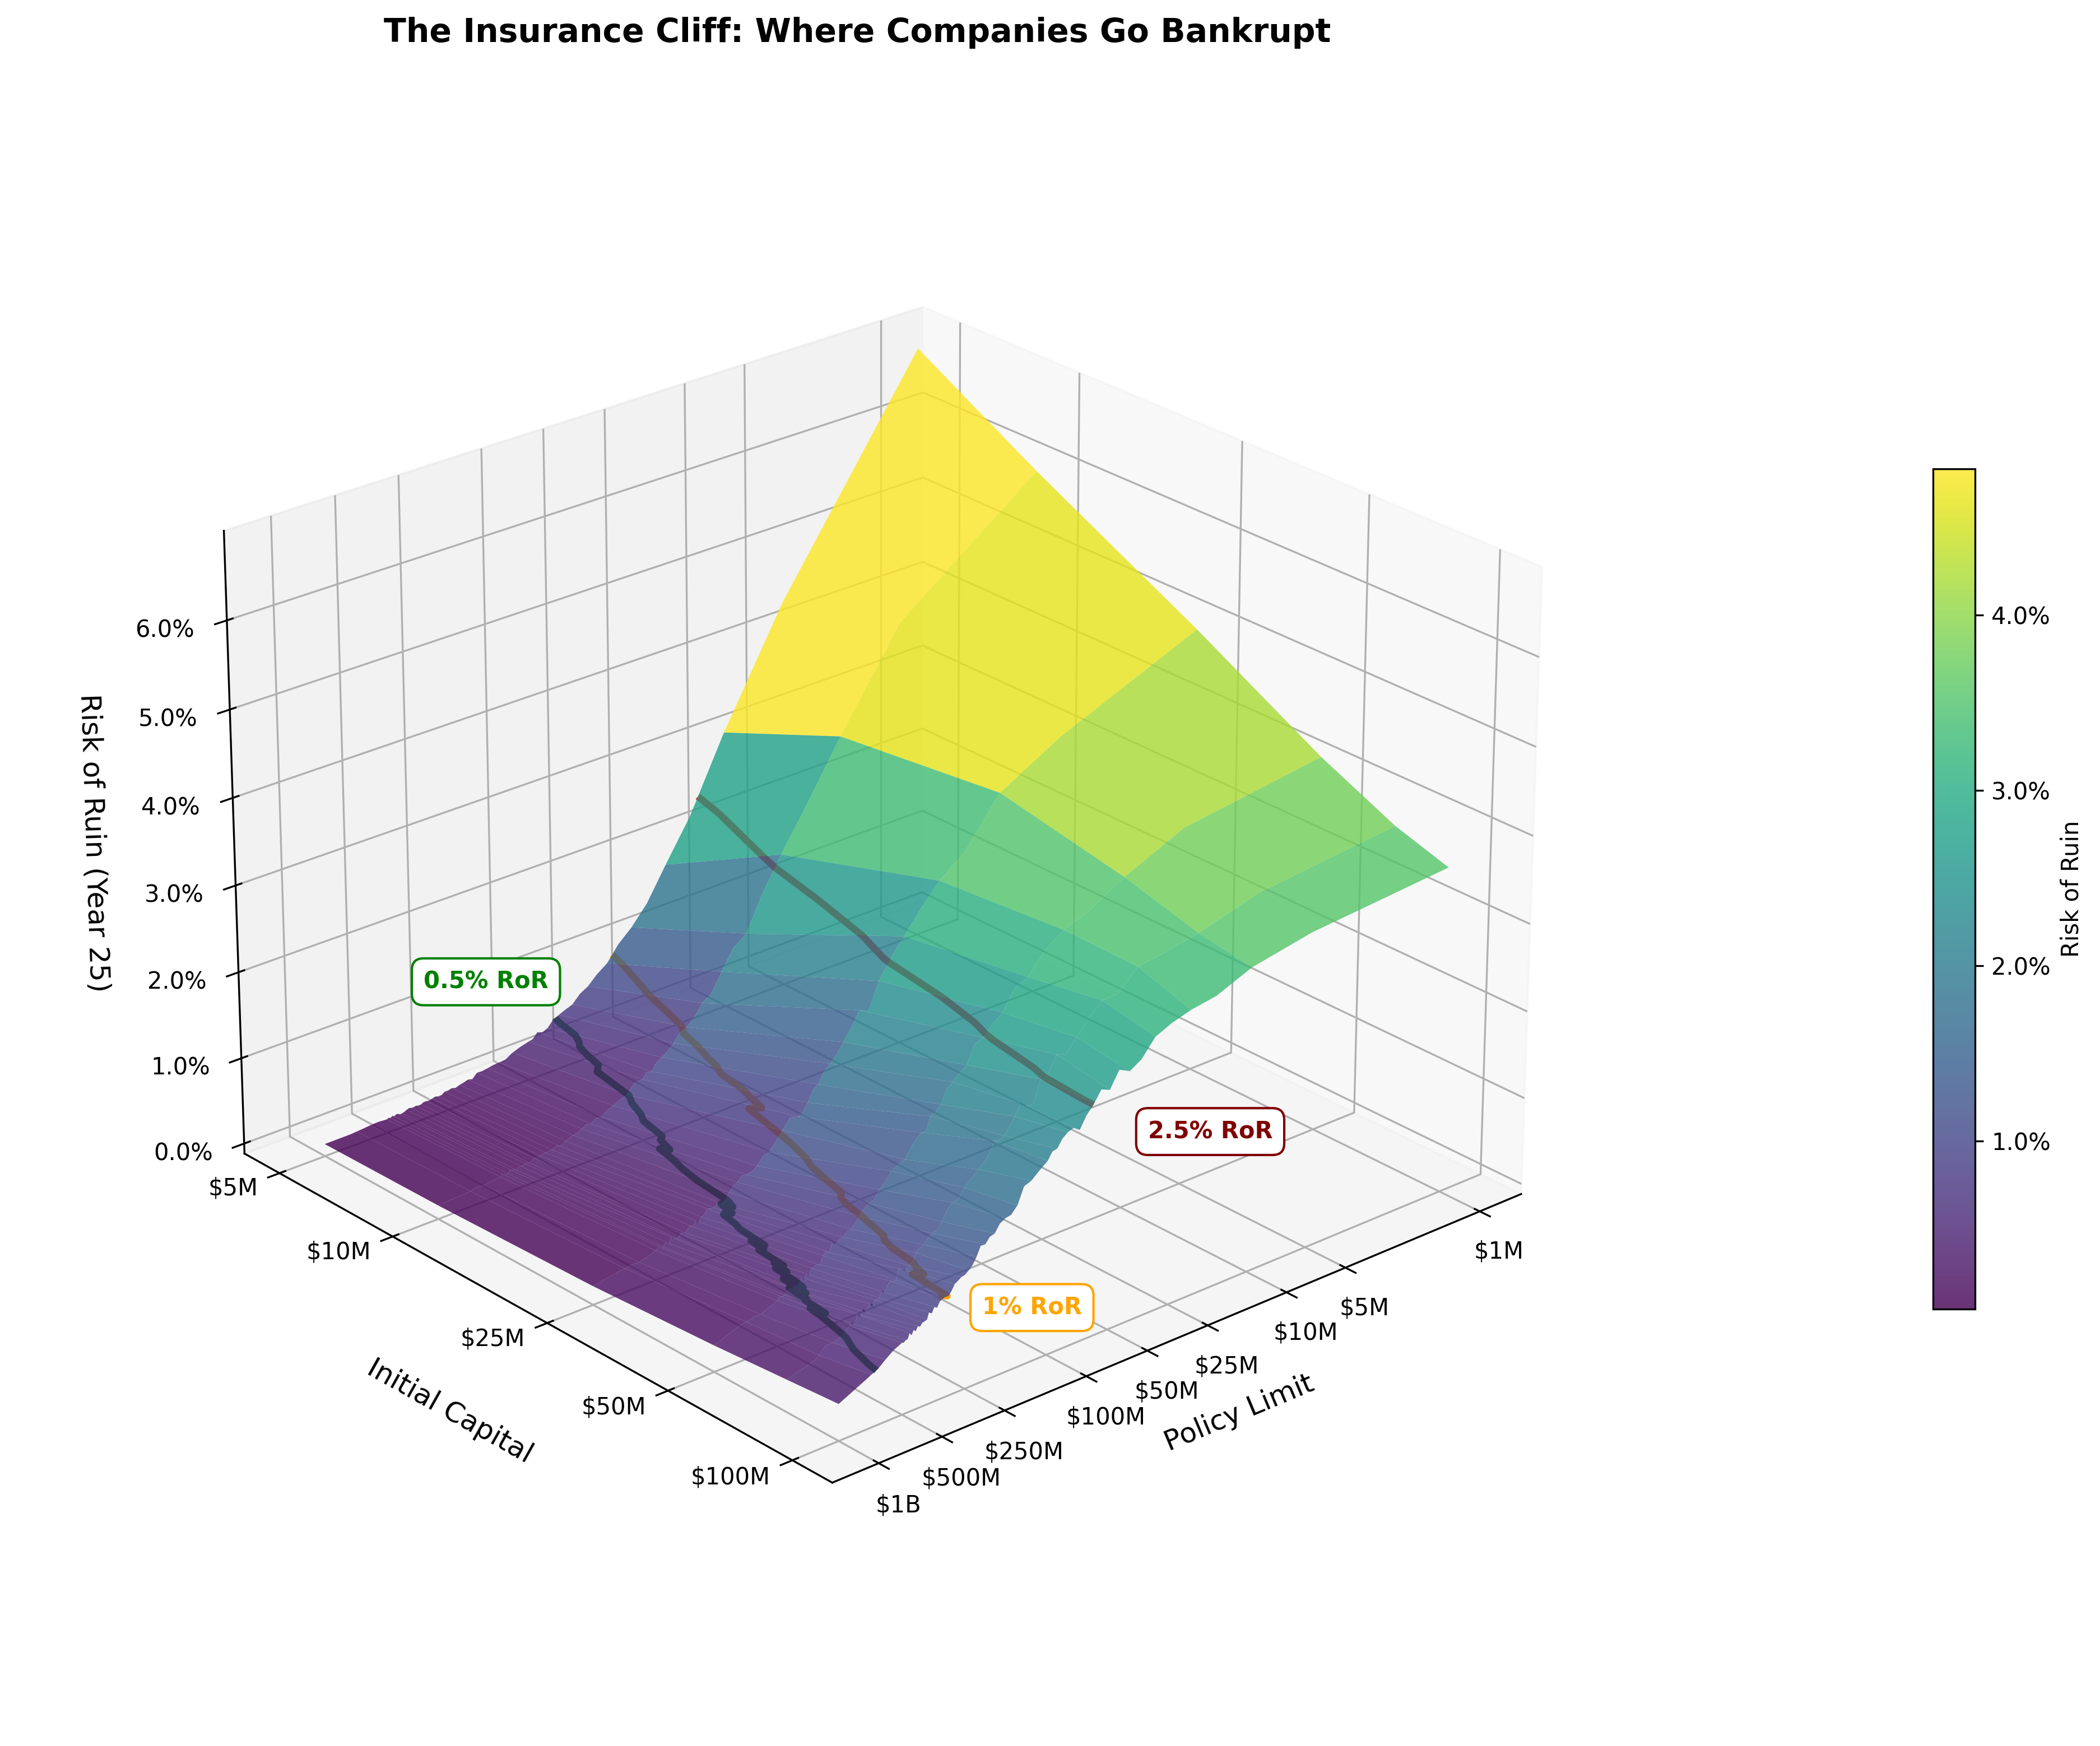

In [160]:
# Create surface plot of Risk of Ruin by Year 25
fig = plt.figure(figsize=(14, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Pivot the data to create a grid for the surface plot
pivot_data = df.pivot_table(
    values='risk_of_ruin_25',
    index='Cap',
    columns='Pol_Lim',
    aggfunc='mean'  # In case there are duplicates
)

# Create custom tick formatter for x-axis (Policy Limit in millions)
x_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
x_tick_positions = np.log10(x_ticks)
x_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in x_ticks]
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels, rotation=0, ha='center')

# Create custom tick formatter for y-axis (Initial Capital in millions)
y_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
y_tick_positions = np.log10(y_ticks)
y_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in y_ticks]
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels, rotation=0, ha='center')

# Create mesh grid
X, Y = np.meshgrid(pivot_data.columns, pivot_data.index)
Z = pivot_data.values

# Convert X and Y to log scale
X = np.log10(X)
Y = np.log10(Y)

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')

# Labels and title
ax.set_xlabel('Policy Limit', fontsize=12, labelpad=10)
ax.set_ylabel('Initial Capital', fontsize=12, labelpad=10)
ax.set_zlabel('Risk of Ruin (Year 25)', fontsize=12, labelpad=10)
ax.set_title('The Insurance Cliff: Where Companies Go Bankrupt', fontsize=14, pad=0, fontweight='bold')

# Add colorbar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='Risk of Ruin', pad=0.1, fraction=0.02, format=plt.FuncFormatter(lambda x, p: f'{x*100:.1f}%'))
# Adjust viewing angle for better visualization
ax.view_init(elev=25, azim=49)

# Center the y-axis tick labels
ax.yaxis.labelpad = 20
for t in ax.yaxis.get_major_ticks():
    t.label1.set_horizontalalignment('right')
    t.label1.set_verticalalignment('bottom')
# Add padding to z-axis tick labels
ax.zaxis.labelpad = 20
ax.tick_params(axis='z', pad=10)
ax.set_box_aspect(None, zoom=0.85)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig = plt.figure(constrained_layout=True)
# Format z-axis as percentages
ax.zaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*100:.1f}%'))

# Draw a prominent contour lines at 0.5%, 1%, and 2.5%
contour_risky = ax.contour(X, Y, Z, levels=[0.005], colors='green', linewidths=3, alpha=1)
contour_neutral = ax.contour(X, Y, Z, levels=[0.01], colors='orange', linewidths=3, alpha=1)
contour_averse = ax.contour(X, Y, Z, levels=[0.025], colors='red', linewidths=3, alpha=1)

# Add text annotation for the 0.5% contour line
ax.text(np.log10(80e6), np.log10(2.3e6), 0.001, '0.5% RoR', color='green', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='green', alpha=1))

# Add text annotation for the 1% contour line
ax.text(np.log10(300e6), np.log10(120e6), 0.01, '1% RoR', color='orange', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='orange', alpha=1))

# Add text annotation for the 2.5% contour line
ax.text(np.log10(15e6), np.log10(70e6), 0.012, '2.5% RoR', color='maroon', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='maroon', alpha=1))

if fig is not ax.figure:
    plt.close(fig)
plt.figure(ax.figure.number)
plt.savefig('cache/insurance_cliff_view_3.png', dpi=300, bbox_inches='tight')
plt.show()

In [164]:
from PIL import Image
from pathlib import Path

animation_source = [
    "cache/insurance_cliff_view_1.png",
    "cache/insurance_cliff_view_2.png",
    "cache/insurance_cliff_view_3.png",
    "cache/insurance_cliff_view_2.png"]

# Load all images
images = [Image.open(img_path) for img_path in animation_source]

# Save as animated GIF
output_path = Path("cache/insurance_cliff_animation.gif")
# Create the animation with two loops: fast then slow
fast_loop = images.copy()

# Create lists of images with their durations
frames = []
durations = []

# Fast loop (500ms per frame)
frames.extend(fast_loop)
durations.extend([200] * len(fast_loop))

# Save with variable frame durations
# Find the maximum dimensions
max_width = max(img.width for img in images)
max_height = max(img.height for img in images)

# Create new images with white background, aligned to the left
aligned_frames = []
for img in frames:
    # Create a new white image with max dimensions
    new_img = Image.new('RGBA', (max_width, max_height), (255, 255, 255, 255))
    # Paste the original image at the top-left (0, 0)
    new_img.paste(img, (0, 0))
    aligned_frames.append(new_img)

# Save with the aligned frames
aligned_frames[0].save(
    output_path,
    save_all=True,
    append_images=aligned_frames[1:],
    duration=durations,
    loop=0  # 0 means loop indefinitely
)

print(f"Animated GIF saved to {output_path}")
print(f"Total frames: {len(images)}")

Animated GIF saved to cache\insurance_cliff_animation.gif
Total frames: 4


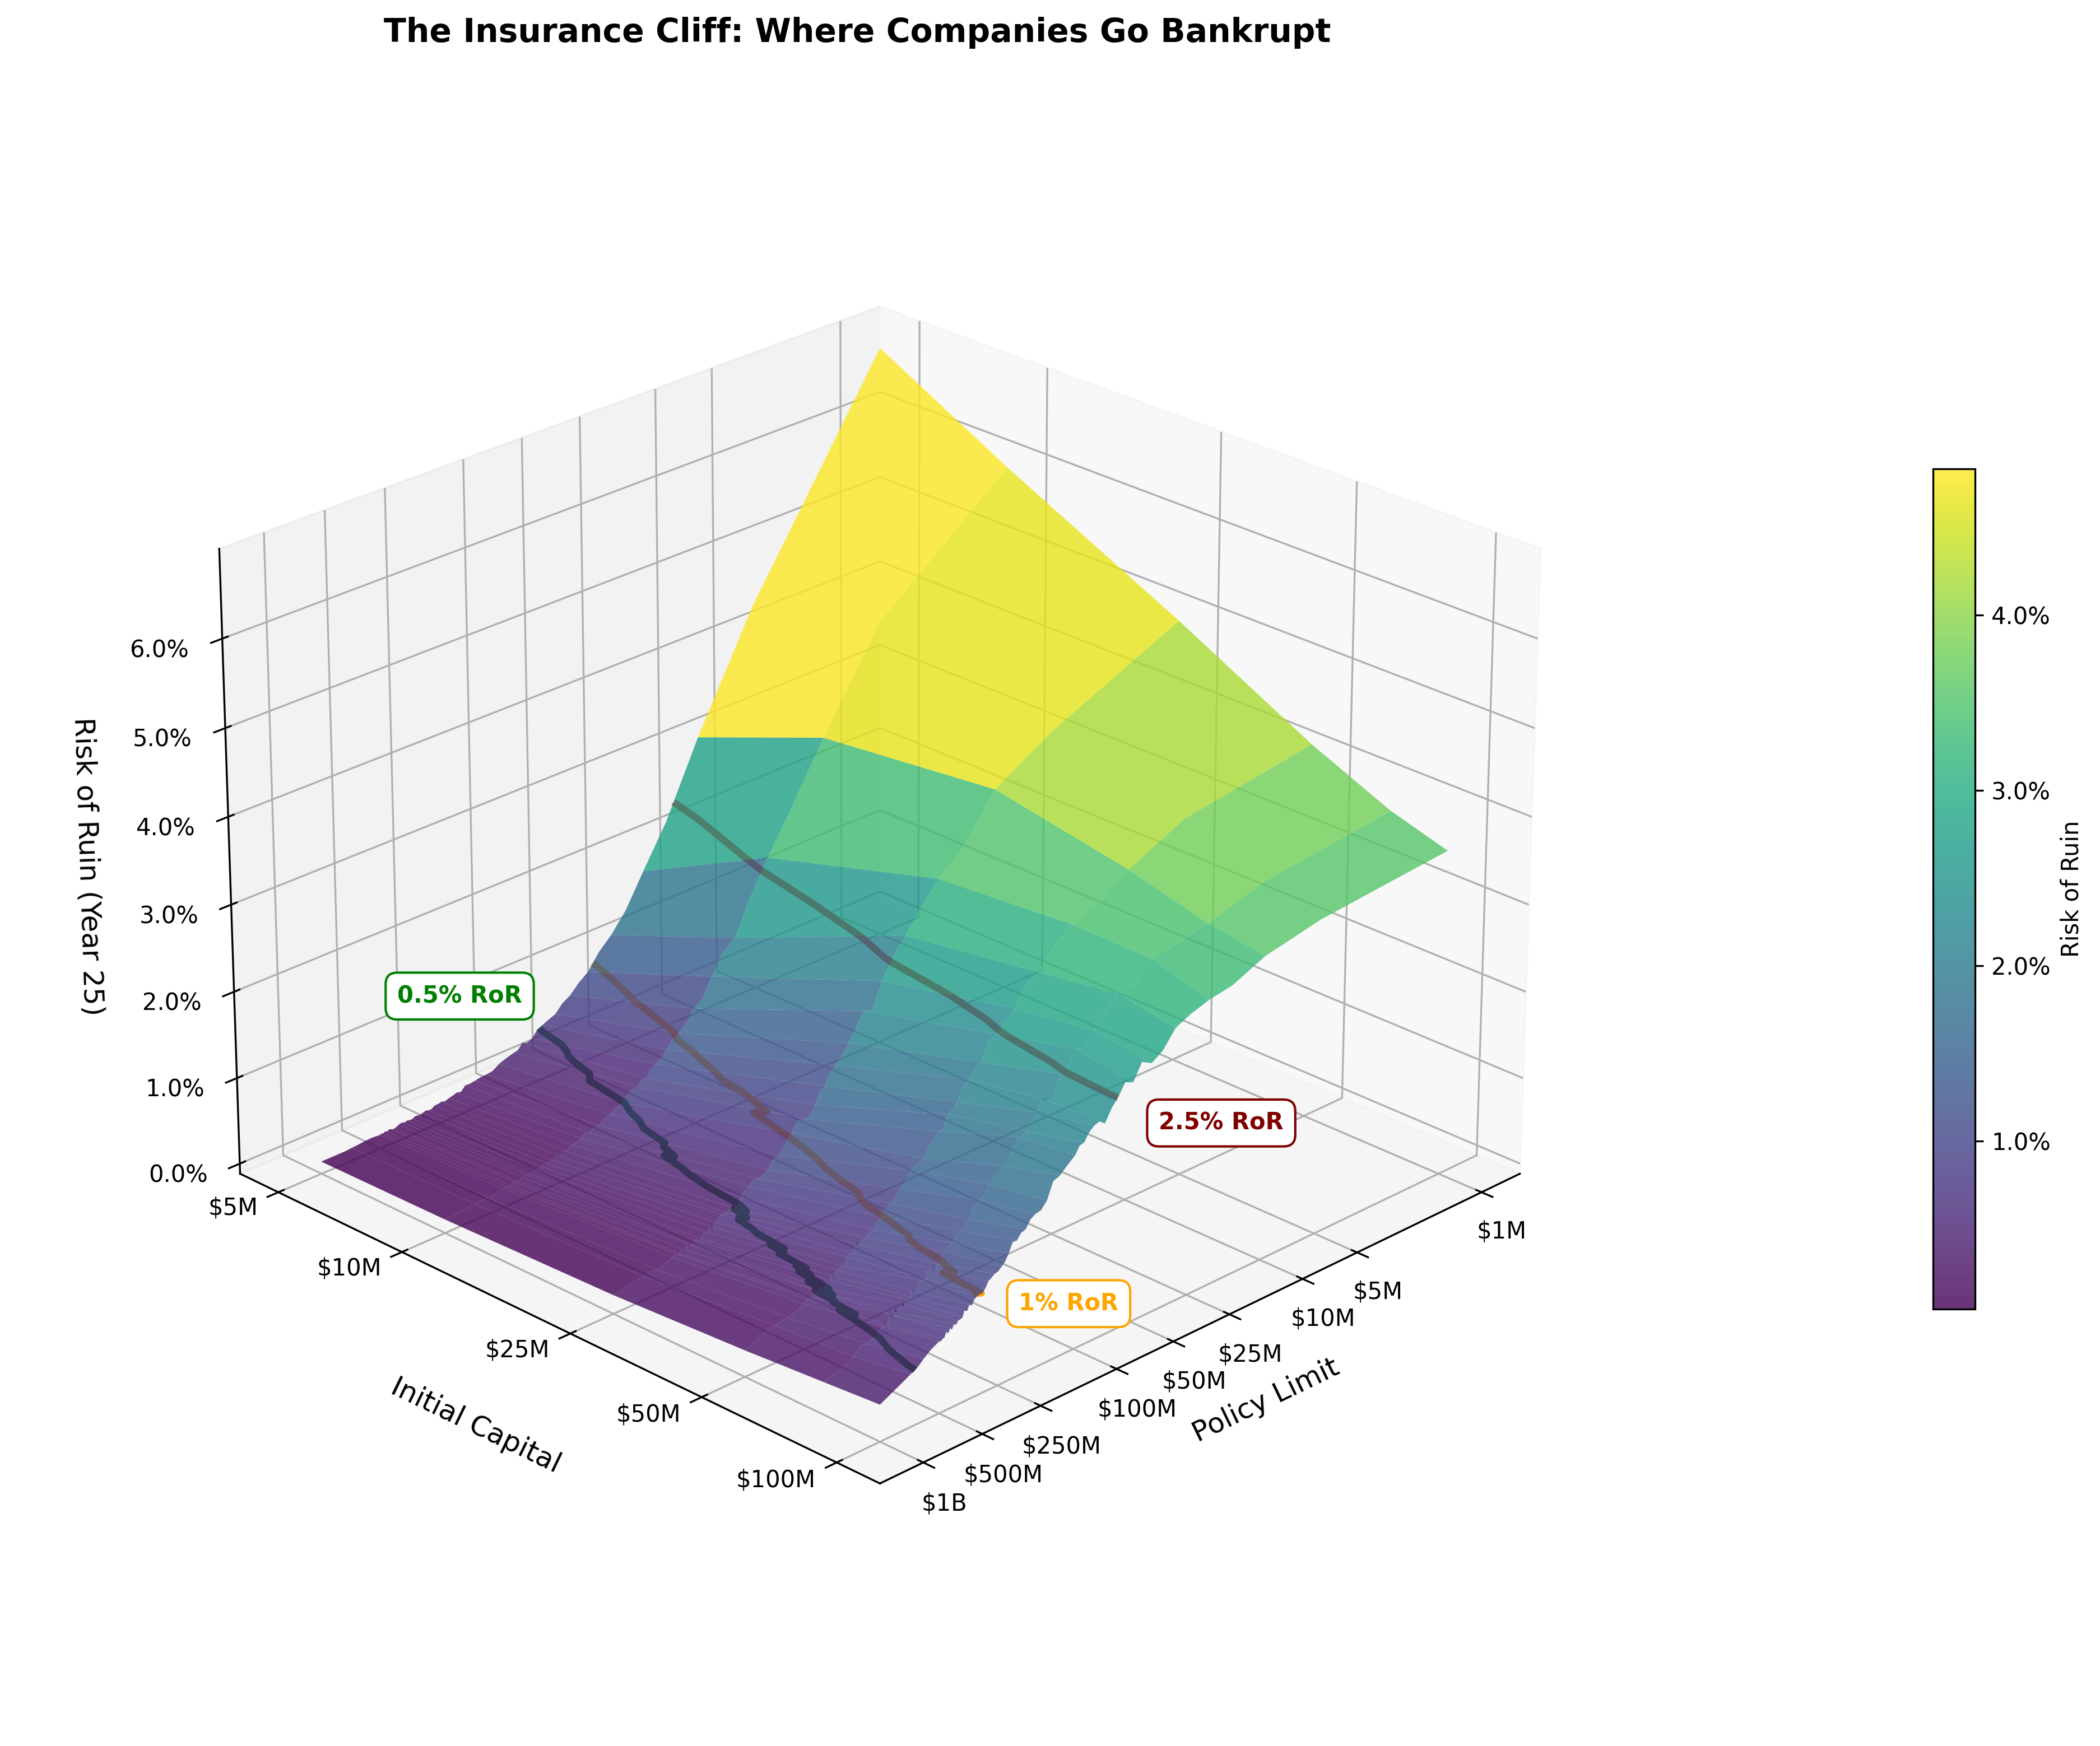

<Figure size 640x480 with 0 Axes>

In [162]:
# Create surface plot of Risk of Ruin by Year 25
fig = plt.figure(figsize=(14, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Pivot the data to create a grid for the surface plot
pivot_data = df.pivot_table(
    values='risk_of_ruin_25',
    index='Cap',
    columns='Pol_Lim',
    aggfunc='mean'  # In case there are duplicates
)

# Create custom tick formatter for x-axis (Policy Limit in millions)
x_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
x_tick_positions = np.log10(x_ticks)
x_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in x_ticks]
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels, rotation=0, ha='center')

# Create custom tick formatter for y-axis (Initial Capital in millions)
y_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
y_tick_positions = np.log10(y_ticks)
y_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in y_ticks]
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels, rotation=0, ha='center')

# Create mesh grid
X, Y = np.meshgrid(pivot_data.columns, pivot_data.index)
Z = pivot_data.values

# Convert X and Y to log scale
X = np.log10(X)
Y = np.log10(Y)

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')

# Labels and title
ax.set_xlabel('Policy Limit', fontsize=12, labelpad=10)
ax.set_ylabel('Initial Capital', fontsize=12, labelpad=10)
ax.set_zlabel('Risk of Ruin (Year 25)', fontsize=12, labelpad=10)
ax.set_title('The Insurance Cliff: Where Companies Go Bankrupt', fontsize=14, pad=0, fontweight='bold')

# Add colorbar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='Risk of Ruin', pad=0.1, fraction=0.02, format=plt.FuncFormatter(lambda x, p: f'{x*100:.1f}%'))
# Adjust viewing angle for better visualization
ax.view_init(elev=25, azim=45)

# Center the y-axis tick labels
ax.yaxis.labelpad = 20
for t in ax.yaxis.get_major_ticks():
    t.label1.set_horizontalalignment('right')
    t.label1.set_verticalalignment('bottom')
# Add padding to z-axis tick labels
ax.zaxis.labelpad = 20
ax.tick_params(axis='z', pad=10)
ax.set_box_aspect(None, zoom=0.85)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig = plt.figure(constrained_layout=True)
# Format z-axis as percentages
ax.zaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x*100:.1f}%'))

# Draw a prominent contour lines at 0.5%, 1%, and 2.5%
contour_risky = ax.contour(X, Y, Z, levels=[0.005], colors='green', linewidths=3, alpha=1)
contour_neutral = ax.contour(X, Y, Z, levels=[0.01], colors='orange', linewidths=3, alpha=1)
contour_averse = ax.contour(X, Y, Z, levels=[0.025], colors='red', linewidths=3, alpha=1)

# Add text annotation for the 0.5% contour line
ax.text(np.log10(80e6), np.log10(2.3e6), 0.001, '0.5% RoR', color='green', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='green', alpha=1))

# Add text annotation for the 1% contour line
ax.text(np.log10(300e6), np.log10(120e6), 0.01, '1% RoR', color='orange', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='orange', alpha=1))

# Add text annotation for the 2.5% contour line
ax.text(np.log10(15e6), np.log10(70e6), 0.012, '2.5% RoR', color='maroon', fontsize=10, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='maroon', alpha=1))

plt.show()

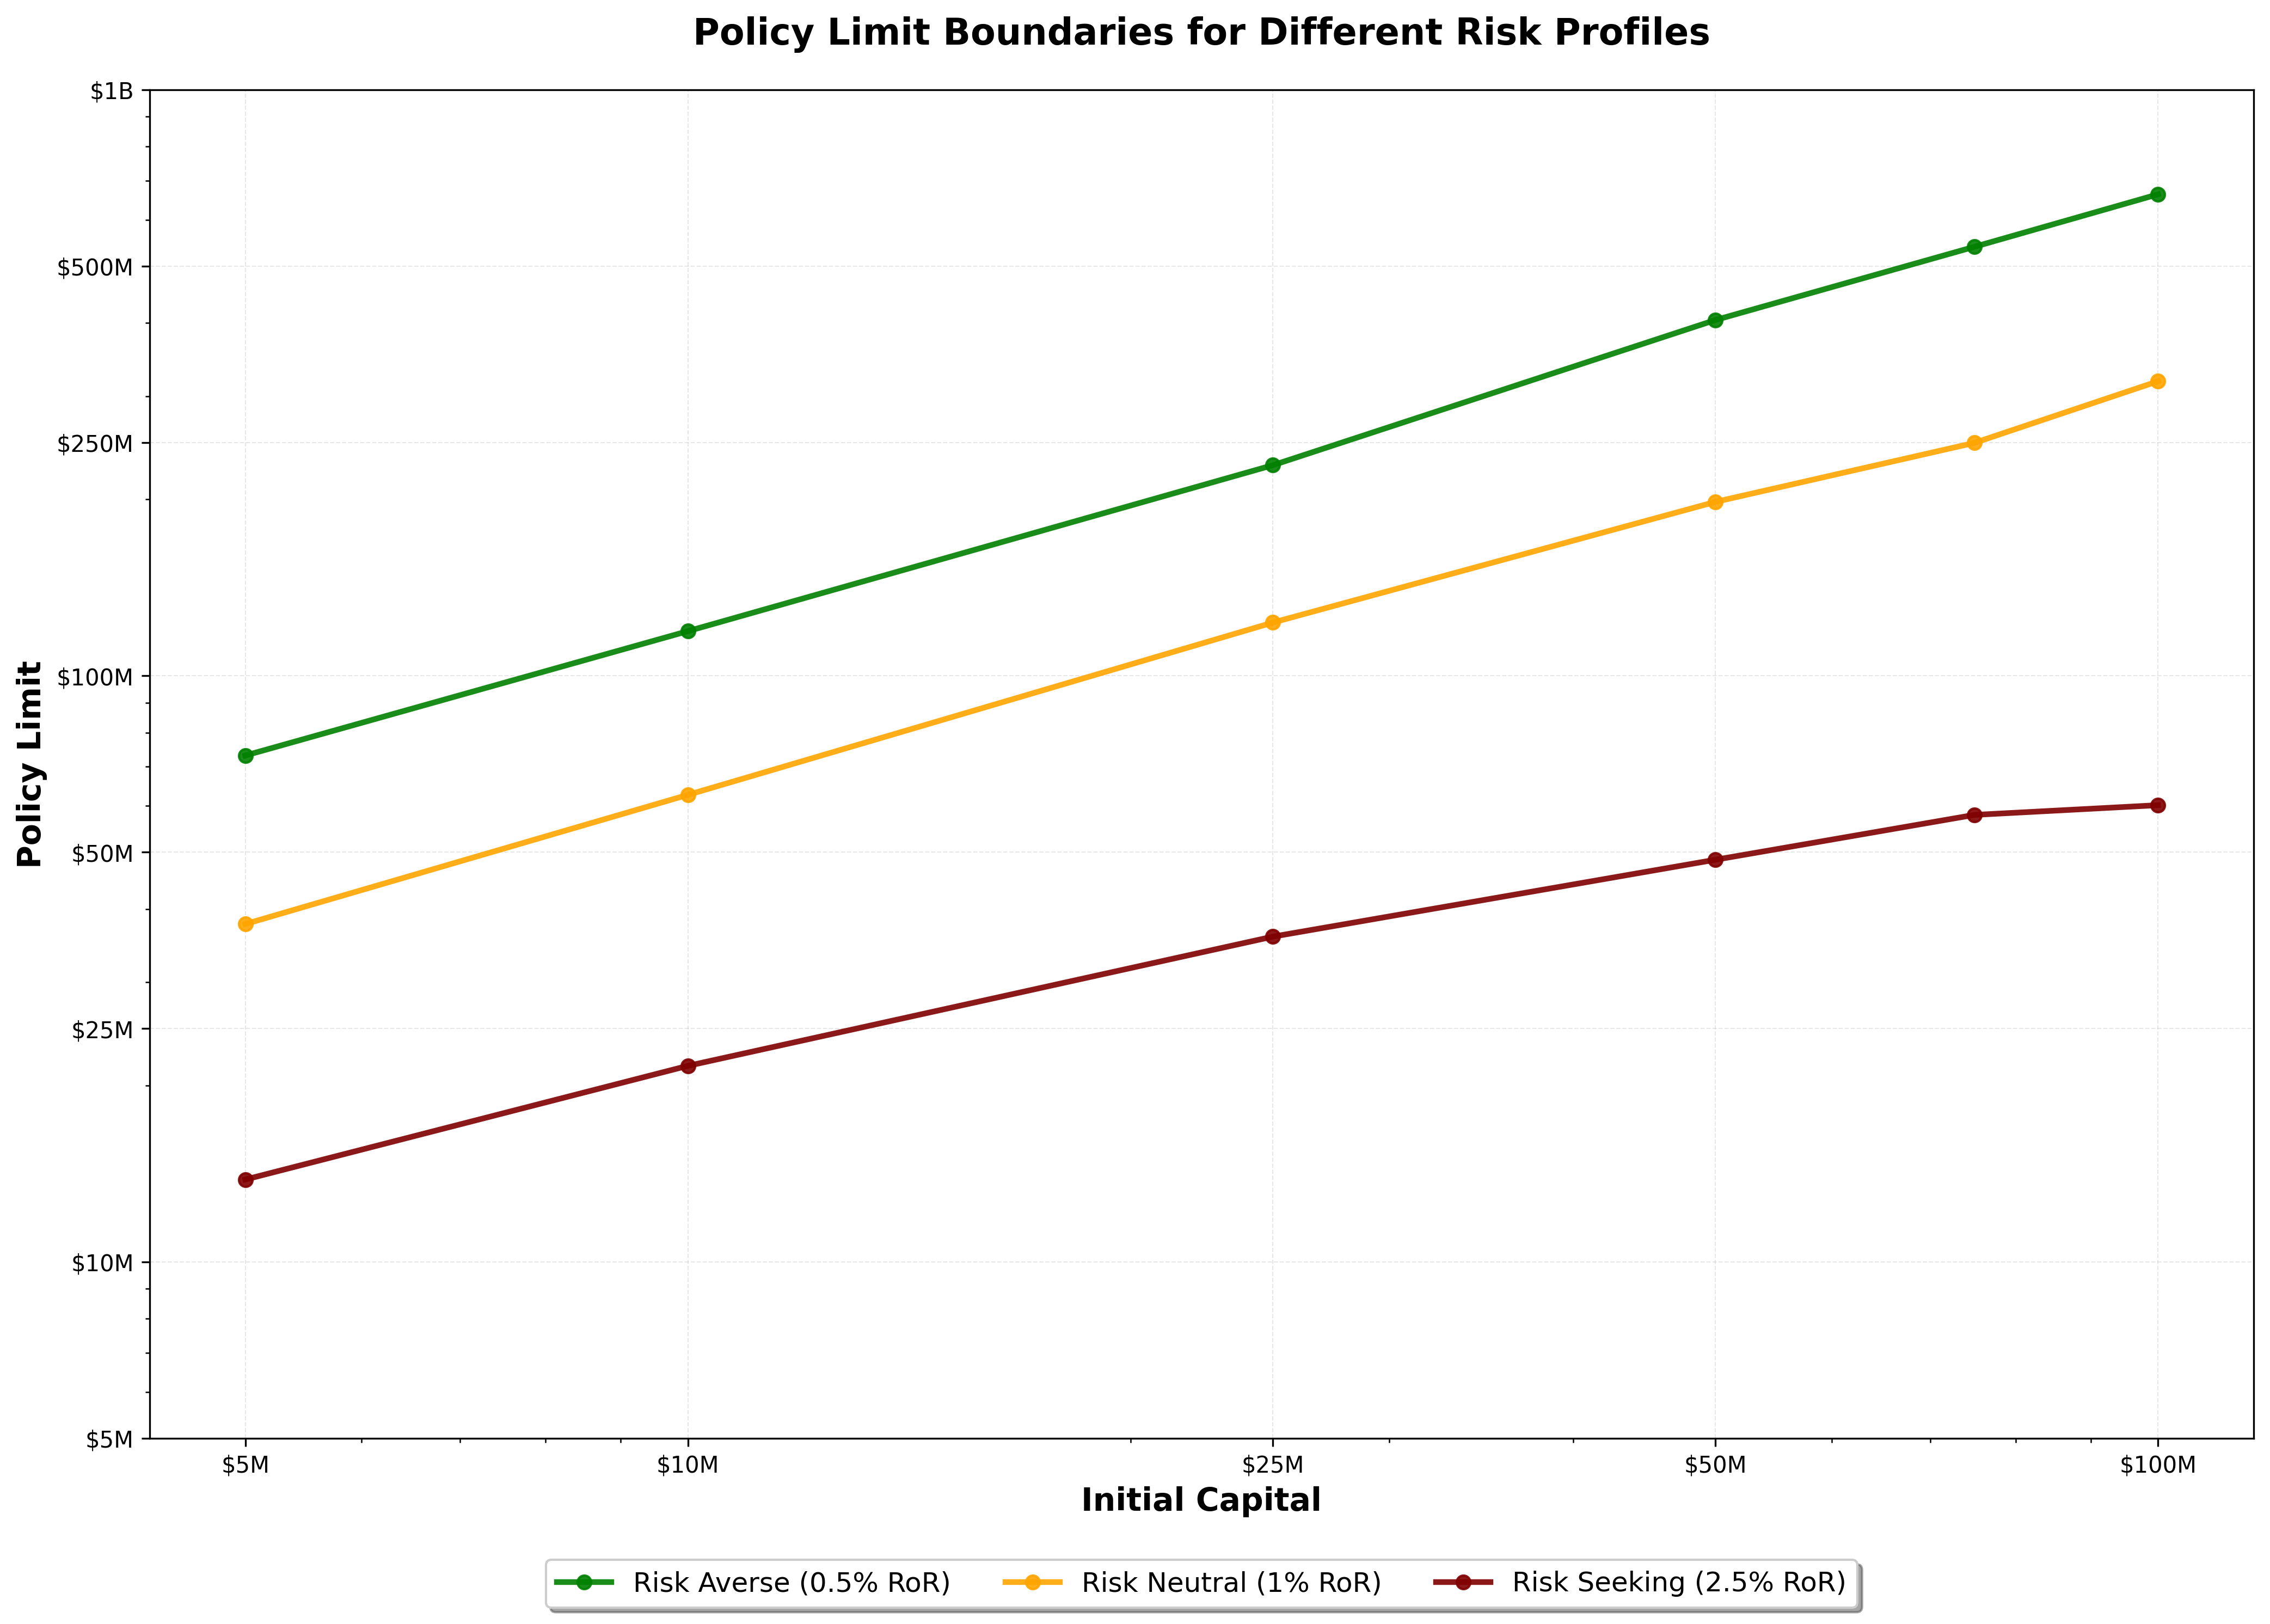

In [169]:
# Create 2D plot of RoR boundaries
fig, ax = plt.subplots(figsize=(14, 10), dpi=300)

# Filter out NaN values for each line to create gaps
df_0p5pct = boundary_df[boundary_df['Pol_Lim_at_0p5pct_RoR'].notna()]
df_1pct = boundary_df[boundary_df['Pol_Lim_at_1pct_RoR'].notna()]
df_2p5pct = boundary_df[boundary_df['Pol_Lim_at_2p5pct_RoR'].notna()]

# Plot the three boundary lines
ax.plot(df_0p5pct['Cap'], df_0p5pct['Pol_Lim_at_0p5pct_RoR'], 
        color='green', linewidth=2.5, marker='o', markersize=6, 
        label='Risk Averse (0.5% RoR)', alpha=0.9)
ax.plot(df_1pct['Cap'], df_1pct['Pol_Lim_at_1pct_RoR'], 
        color='orange', linewidth=2.5, marker='o', markersize=6, 
        label='Risk Neutral (1% RoR)', alpha=0.9)
ax.plot(df_2p5pct['Cap'], df_2p5pct['Pol_Lim_at_2p5pct_RoR'], 
        color='maroon', linewidth=2.5, marker='o', markersize=6, 
        label='Risk Seeking (2.5% RoR)', alpha=0.9)

# Set logarithmic scales
ax.set_xscale('log')
ax.set_yscale('log')

# Create custom tick formatter for x-axis (Initial Capital)
x_ticks = [5e6, 10e6, 25e6, 50e6, 100e6]
x_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in x_ticks]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

# Create custom tick formatter for y-axis (Policy Limit)
y_ticks = [5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
y_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in y_ticks]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)

# Labels and title
ax.set_xlabel('Initial Capital', fontsize=14, fontweight='bold')
ax.set_ylabel('Policy Limit', fontsize=14, fontweight='bold')
ax.set_title('Policy Limit Boundaries for Different Risk Profiles', fontsize=16, fontweight='bold', pad=20)

# Add subtle grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Add legend centered below the graph
ax.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.08), 
          ncol=3, fontsize=12, title_fontsize=13, frameon=True, 
          fancybox=True, shadow=True)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('cache/limit_boundaries_for_different_risk_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

## Graphs of Returns

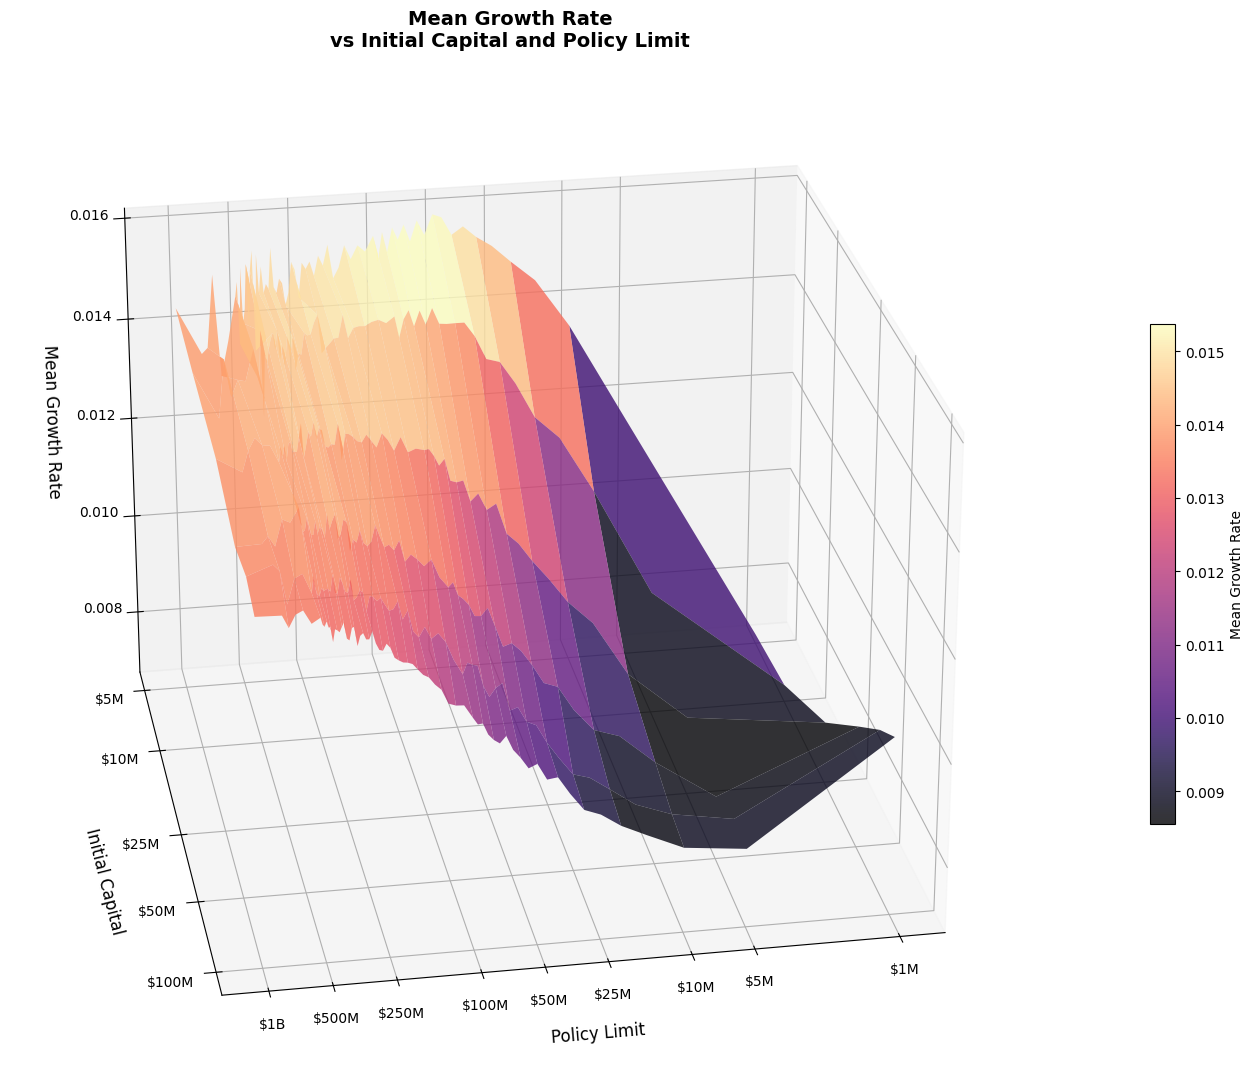

<Figure size 640x480 with 0 Axes>

In [76]:
# Create surface plot of Risk of Ruin by Year 25
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Pivot the data to create a grid for the surface plot
pivot_data = df.pivot_table(
    values='growth_rate_mean',
    index='Cap',
    columns='Pol_Lim',
    aggfunc='mean'  # In case there are duplicates
)

# Create custom tick formatter for x-axis (Policy Limit in millions)
x_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
x_tick_positions = np.log10(x_ticks)
x_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in x_ticks]
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels, rotation=0, ha='center')

# Create custom tick formatter for y-axis (Initial Capital in millions)
y_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
y_tick_positions = np.log10(y_ticks)
y_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in y_ticks]
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels, rotation=0, ha='center')

# Create mesh grid
X, Y = np.meshgrid(pivot_data.columns, pivot_data.index)
Z = pivot_data.values

# Convert X and Y to log scale
X = np.log10(X)
Y = np.log10(Y)

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='magma', alpha=0.8, edgecolor='none')

# Labels and title
ax.set_xlabel('Policy Limit', fontsize=12, labelpad=10)
ax.set_ylabel('Initial Capital', fontsize=12, labelpad=10)
ax.set_zlabel('Mean Growth Rate', fontsize=12, labelpad=10)
ax.set_title('Mean Growth Rate\nvs Initial Capital and Policy Limit', fontsize=14, pad=20, fontweight='bold')

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='Mean Growth Rate', pad=0.1, fraction=0.02)

# Adjust viewing angle for better visualization
ax.view_init(elev=25, azim=80)

# Center the y-axis tick labels
ax.yaxis.labelpad = 20
for t in ax.yaxis.get_major_ticks():
    t.label1.set_horizontalalignment('right')
    t.label1.set_verticalalignment('bottom')
# Add padding to z-axis tick labels
ax.zaxis.labelpad = 20
ax.tick_params(axis='z', pad=10)
ax.set_box_aspect(None, zoom=1.1)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig = plt.figure(constrained_layout=True)
plt.show()

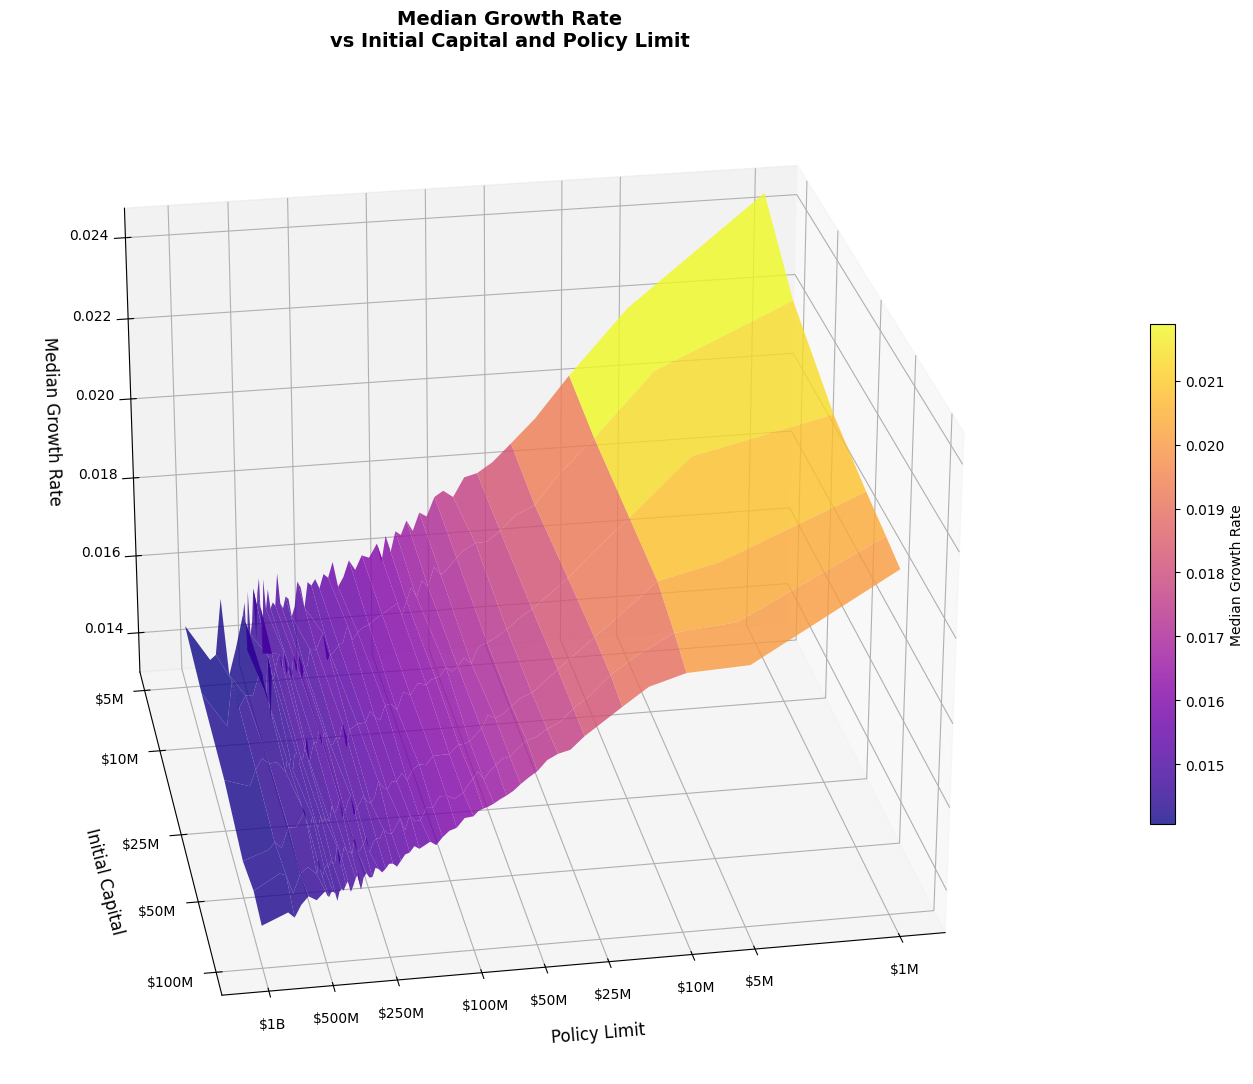

<Figure size 640x480 with 0 Axes>

In [77]:
# Create surface plot of Risk of Ruin by Year 25
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Pivot the data to create a grid for the surface plot
pivot_data = df.pivot_table(
    values='growth_rate_q50',
    index='Cap',
    columns='Pol_Lim',
    aggfunc='median'  # In case there are duplicates
)

# Create custom tick formatter for x-axis (Policy Limit in millions)
x_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
x_tick_positions = np.log10(x_ticks)
x_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in x_ticks]
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels, rotation=0, ha='center')

# Create custom tick formatter for y-axis (Initial Capital in millions)
y_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
y_tick_positions = np.log10(y_ticks)
y_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in y_ticks]
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels, rotation=0, ha='center')

# Create mesh grid
X, Y = np.meshgrid(pivot_data.columns, pivot_data.index)
Z = pivot_data.values

# Convert X and Y to log scale
X = np.log10(X)
Y = np.log10(Y)

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.8, edgecolor='none')

# Labels and title
ax.set_xlabel('Policy Limit', fontsize=12, labelpad=10)
ax.set_ylabel('Initial Capital', fontsize=12, labelpad=10)
ax.set_zlabel('Median Growth Rate', fontsize=12, labelpad=10)
ax.set_title('Median Growth Rate\nvs Initial Capital and Policy Limit', fontsize=14, pad=20, fontweight='bold')

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='Median Growth Rate', pad=0.1, fraction=0.02)

# Adjust viewing angle for better visualization
ax.view_init(elev=25, azim=80)

# Center the y-axis tick labels
ax.yaxis.labelpad = 20
for t in ax.yaxis.get_major_ticks():
    t.label1.set_horizontalalignment('right')
    t.label1.set_verticalalignment('bottom')
# Add padding to z-axis tick labels
ax.zaxis.labelpad = 20
ax.tick_params(axis='z', pad=10)
ax.set_box_aspect(None, zoom=1.1)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig = plt.figure(constrained_layout=True)
plt.show()

In [78]:

# Pivot the data to create a grid for the surface plot
pivot_data = df.pivot_table(
    values=['growth_rate_mean', 'growth_rate_q50'],
    index='Cap',
    columns='Pol_Lim',
    aggfunc='mean'  # In case there are duplicates
)

pivot_data.values

array([[0.00691781, 0.01159104, 0.01361205, 0.01456764, 0.01497115,
        0.01530816, 0.01550551, 0.01573077, 0.01557823, 0.01593801,
        0.01600699, 0.01561072, 0.01590668, 0.01550412, 0.01584263,
        0.01555414, 0.01579953, 0.01532188, 0.01572123, 0.01512869,
        0.01565609, 0.0153599 , 0.01549125, 0.01522876, 0.0155085 ,
        0.01507492, 0.01487134, 0.01554181, 0.01513663, 0.0153368 ,
        0.01494471, 0.01523294, 0.01509071, 0.01521892, 0.0145403 ,
        0.01509269, 0.01524931, 0.01464673, 0.01440252, 0.01484031,
        0.01493297, 0.01465691, 0.01477415, 0.01555211, 0.0147475 ,
        0.0148459 , 0.01467411, 0.0151971 , 0.01467325, 0.01544239,
        0.01353321, 0.015521  , 0.01513345, 0.01393158, 0.01526258,
        0.01438759, 0.01409458, 0.01520098, 0.01369382, 0.01492495,
        0.01464923, 0.01375922, 0.01307735, 0.01509947, 0.01365611,
        0.01354162, 0.01448526, 0.02448452, 0.02185238, 0.02025904,
        0.01922959, 0.01864041, 0.01819336, 0.01

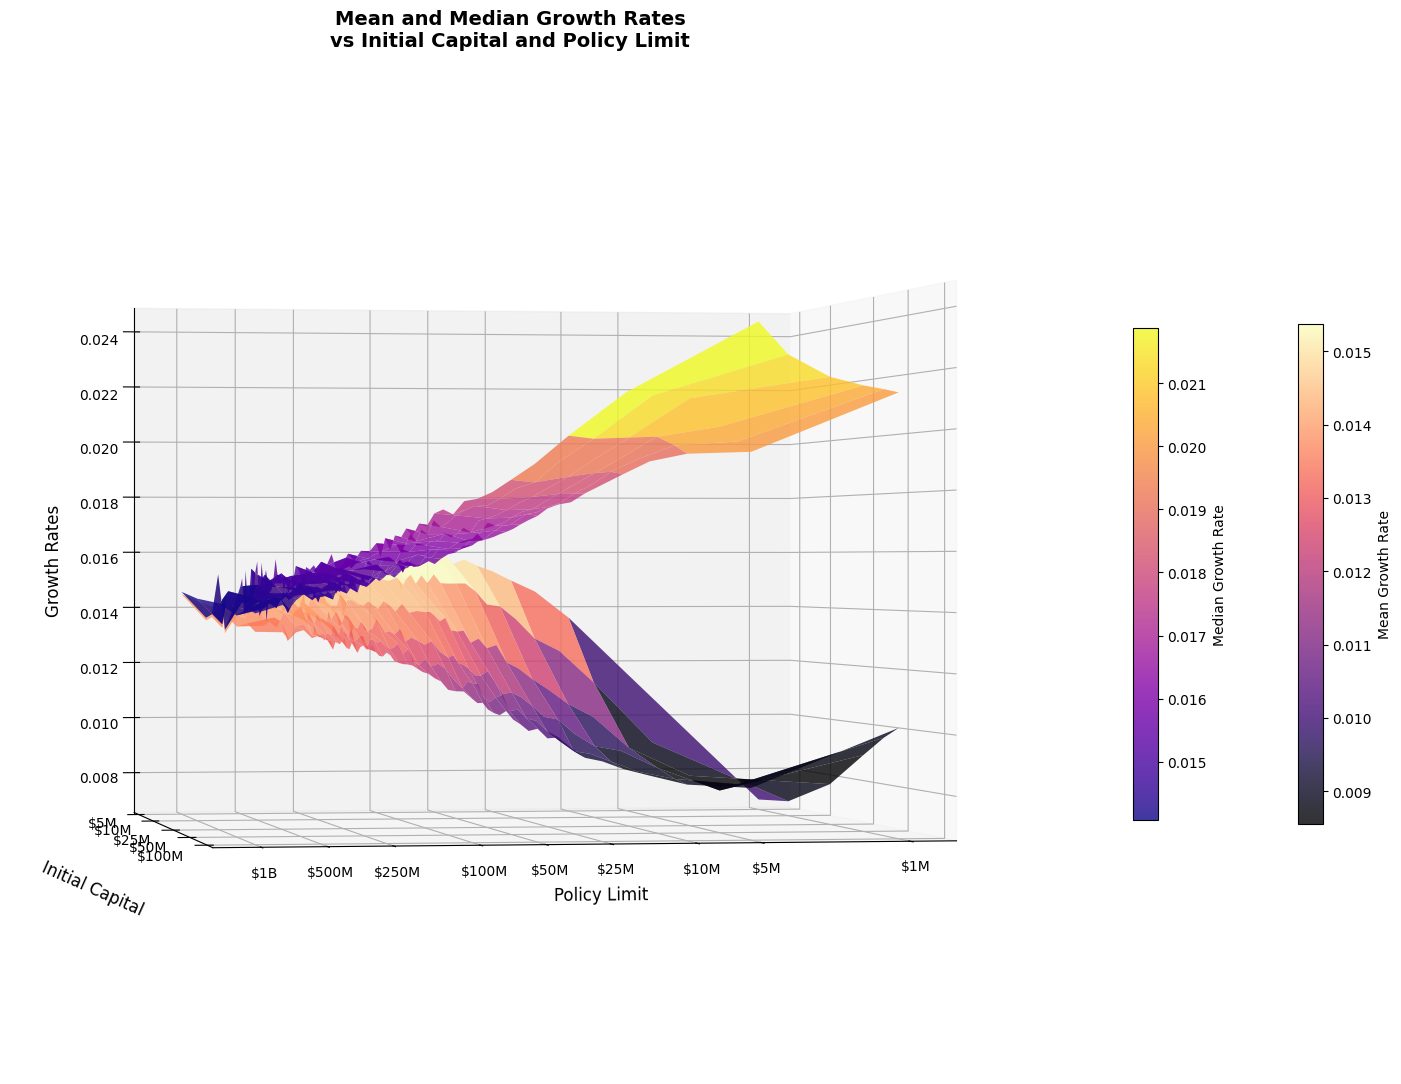

<Figure size 640x480 with 0 Axes>

In [79]:
# Create surface plot of Risk of Ruin by Year 25
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Pivot the data to create a grid for the surface plot
pivot_data = df.pivot_table(
    values='growth_rate_mean',
    index='Cap',
    columns='Pol_Lim',
    aggfunc='mean'  # In case there are duplicates
)

pivot_data_median = df.pivot_table(
    values='growth_rate_q50',
    index='Cap',
    columns='Pol_Lim',
    aggfunc='mean'  # In case there are duplicates
)

# Create custom tick formatter for x-axis (Policy Limit in millions)
x_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
x_tick_positions = np.log10(x_ticks)
x_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in x_ticks]
ax.set_xticks(x_tick_positions)
ax.set_xticklabels(x_tick_labels, rotation=0, ha='center')

# Create custom tick formatter for y-axis (Initial Capital in millions)
y_ticks = [1e6, 5e6, 10e6, 25e6, 50e6, 100e6, 250e6, 500e6, 1e9]
y_tick_positions = np.log10(y_ticks)
y_tick_labels = [f'${int(val/1e6)}M' if val < 1e9 else f'${int(val/1e9)}B' for val in y_ticks]
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels, rotation=0, ha='center')

# Create mesh grid
X, Y = np.meshgrid(pivot_data.columns, pivot_data.index)
Z = pivot_data.values
Z_median = pivot_data_median.values

# Convert X and Y to log scale
X = np.log10(X)
Y = np.log10(Y)

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='magma', alpha=0.8, edgecolor='none')
surf2 = ax.plot_surface(X, Y, Z_median, cmap='plasma', alpha=0.8, edgecolor='none')

# Labels and title
ax.set_xlabel('Policy Limit', fontsize=12, labelpad=10)
ax.set_ylabel('Initial Capital', fontsize=12, labelpad=10)
ax.set_zlabel('Growth Rates', fontsize=12, labelpad=10)
ax.set_title('Mean and Median Growth Rates\nvs Initial Capital and Policy Limit', fontsize=14, pad=20, fontweight='bold')

# Add colorbars
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='Mean Growth Rate', pad=0.1, fraction=0.02)
fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=20, label='Median Growth Rate', pad=0.1, fraction=0.02)

# Adjust viewing angle for better visualization
ax.view_init(elev=0, azim=80)

# Center the y-axis tick labels
ax.yaxis.labelpad = 20
for t in ax.yaxis.get_major_ticks():
    t.label1.set_horizontalalignment('right')
    t.label1.set_verticalalignment('bottom')
# Add padding to z-axis tick labels
ax.zaxis.labelpad = 20
ax.tick_params(axis='z', pad=10)
ax.set_box_aspect(None, zoom=1.1)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig = plt.figure(constrained_layout=True)
plt.show()